<a href="https://colab.research.google.com/github/nferrucho/NPL/blob/main/curso2/ciclo2/M5U2_Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://drive.google.com/uc?export=view&id=1Md0grlXXV4fB0bkYuMWzBiS64RvjaFGX" alt = "Encabezado MLDS" width = "100%">  </img>

# **Taller 2: Redes Neuronales con *Keras***
---

En este taller deberá entrenar una red neuronal de clasificación para el [conjunto de datos Digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) del repositorio de la *UCI* usando *Tensorflow*.

Ejecute las siguientes celdas para conectarse a UNCode:



In [ ]:
!pip install rlxcrypt

In [ ]:
!wget --no-cache -O session.pye -q https://raw.githubusercontent.com/JuezUN/INGInious/master/external%20libs/session.pye

In [ ]:
import rlxcrypt
import session

grader = session.LoginSequence("DLIAAPCP-GroupMLDS-5-2024-2@a4526b56-9e9e-4349-8e31-7988c2f739ca")

Ejecute la siguiente celda para importar y configurar las librerías usadas:

In [ ]:
!pip install -U scikit-learn

# Librerías de utilidad para manipulación y visualización de datos.
from numbers import Number
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

#Importamos tensorflow
import tensorflow as tf
tf.config.run_functions_eagerly(True)
# Ignorar warnings.
import warnings
warnings.filterwarnings('ignore')

# Seleccionamos las semillas para efectos de reproducibilidad
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# Versiones de las librerías usadas.
!python --version
print('NumPy', np.__version__)
print('Tensorflow', tf.__version__)

Esta actividad se realizó con las siguientes versiones:
*  Python 3.9.16
*  NumPy 1.22.4
*  Tensorflow 2.12.0


## **Cargar datos**
---

Lo primero que vamos a hacer es cargar los datos, y luego usted deberá construir una serie de funciones para crear todo el flujo de trabajo con los datos y el modelo.

El conjunto de datos cuenta con imágenes de dígitos escritos a mano, de tamaño $8\times8$, es decir, cada imagen se representa por un vector de $64$ pixeles. En total son por tanto 10 clases diferentes.

In [ ]:
from sklearn import datasets
from sklearn import model_selection
X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test =  model_selection.train_test_split(X, y, test_size = 0.4, stratify=y, random_state = 50)

In [ ]:
print('Un ejemplo de imagen:')
plt.gray()
plt.matshow(np.reshape(X_train[0], (-1, 8)))
plt.show()
print("El shape de X es:", X.shape)
print("Número de muestras de entrenamiento =", X_train.shape[0])
print("Número de muestras de prueba =", X_test.shape[0])

**Salida esperada**
```
Un ejemplo de imagen:
<Figure size 432x288 with 0 Axes>
```
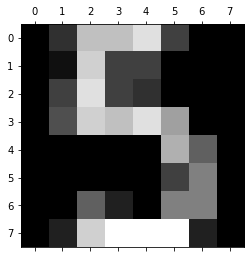
```
El shape de X es: (1797, 64)
Número de muestras de entrenamiento = 1078
Número de muestras de prueba = 719
```


Tenemos en total 1797 muestras de 64 dimensiones para diez clases diferentes.

> **La tarea es incremental, por lo tanto es recomendable resolver los puntos en orden.**


# **1. Clasificación multiclase**
---
Cuando un dataset tiene etiquetas que pertenecen a más de dos categorías para clasificación, no podemos utilizar una salida con activación logística (*sigmoid*) ni una pérdida binaria ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)). Una alternativa es utilizar una salida con activación tipo *softmax*, la cual, nos permitirá saber el grado de certeza con el que la red clasifica a cada clase y una pérdida conocida como entropía cruzada categórica ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)) comúnmente usada cuando la salida es *softmax*.

Por ejemplo, supongamos que la salida de la última capa de tres neuronas es la siguiente:
```
z = [[5], [3], [4]]
```
Entonces, la función de activación *softmax*, definida por
$$
\sigma(z)_i = \frac{e^{x_i}}{\sum_{i=1}^{n}e^{x_i}}, i \in \{1,2,...,n\},
$$
aplicada sobre la salida del modelo, dará como resultado
```
[[0.665], [0.090], [0.245]]
```
El resultado anterior se interpreta como que el modelo está haciendo una predicción hacia la clase `0`, porque es la posición que obtuvo el valor más alto.


## **1.1 Representación *One-hot***
---

Cuando la función de activación de la salida es de tipo *softmax*, las etiquetas se deben codificar como *one-hot encoding*. Por ejemplo, si tuvieramos 3 clases, la última capa de la red neuronal para clasificación debe tener tres neuronas; las predicciones del modelo serán de tres dimensiones. Por tanto las etiquetas deben tener también tres dimensiones: `[1,0,0], [0,1,0], [0,0,1]` para las clases `0`, `1` y `2` respectivamente.

Usando la función [`tf.keras.utils.to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) complete la función `one_hot_labels` que debe recibir las etiquetas `y` del conjunto de datos y devolver la representación *one-hot*.

**Entrada**:

* **`y_train`**: `np.array`, un arreglo de etiquetas del conjunto de entrenamiento, de tamaño `(l, )`, siendo `l` el número de muestras de la partición de entrenamiento
* **`y_test`**: `np.array`, un arreglo de etiquetas del conjunto de entrenamiento, de tamaño `(m, )`, siendo `m` el número de muestras de la partición de prueba.

**Salida**:
* **`y_train_ohe`**: `np.array`, etiquetas *one-hot* del conjunto de entrenamiento, un arreglo de *NumPy* de tamaño `(l, c)`, siendo `c` el número de clases del conjunto de datos.
* **`y_test_ohe`**:  `np.array`, etiquetas *one-hot* del conjunto de prueba, un arreglo de *NumPy* de tamaño `(m, c)`, siendo `c` el número de clases del conjunto de datos.

In [ ]:
# FUNCIÓN CALIFICADA one_hot_labels:
def one_hot_labels(y_train, y_test):
    # Ingrese su código aquí
    y_train_ohe = -1
    y_test_ohe = -1
    return y_train_ohe, y_test_ohe

In [ ]:
#TEST_CELL
y_trial_tr = np.array([0, 1, 0, 0, 0, 0, 1, 2, 1, 2])
y_trial_te = np.array([0, 1, 2])
y_tr_ohe, y_te_ohe = one_hot_labels(y_trial_tr, y_trial_te)
print("Para las etiquetas y =",y_trial_tr,"la representación one-hot es:\n", y_tr_ohe)
print("Para las etiquetas y =",y_trial_te,"la representación one-hot es:\n", y_te_ohe)

**Salida esperada**
```python
Para las etiquetas y = [0 1 0 0 0 0 1 2 1 2] la representación one-hot es:
 [[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
Para las etiquetas y = [0 1 2] la representación one-hot es:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 1_1_1", globals())

In [ ]:
grader.run_test("Test 1_1_2", globals())

In [ ]:
grader.run_test("Test 1_1_3", globals())

## **1.2 Definición del modelo**
---

Ahora vamos a definir la arquitectura del modelo. Complete la función `define_model`, que crea un modelo en **Keras** con las siguientes especificaciones:

* Debe utilizar el API funcional de **Keras** (no puede ser un modelo secuencial).
* Debe tener una capa de entrada con las dimensiones del dataset.
* Debe permitir agregar una serie de capas densa con activación *ReLU* (por lo menos una).
* Debe tener una capa densa de salida con tantas unidades como el número de categorías de las etiquetas a clasificar y con una activación *softmax*.

**Entrada**:

* **`input_shape`**: `int`, un número entero correspondiente a la dimensión de entrada del modelo.
* **`hidden_layers`**: `int`, un número entero correspondiente al número de capas ocultas.
* **`hidden_units`**: `int`, un número entero correspondiente al número de neuronas de las capas ocultas.
* **`output_units`**: `int`, un número entero correspondiente al número de neuronas de la capa de salida.

**Salida**:
* **`model`**: `tf.keras.Model`, un modelo funcional de red neuronal en **Keras**.

In [ ]:
# FUNCIÓN CALIFICADA define_model:

def define_model(input_shape, hidden_layers, hidden_units, output_units):
    # Fijamos una semilla para efectos de reproducibiidad
    tf.keras.utils.set_random_seed(0)
    input_layer = tf.keras.layers.Input(shape=(input_shape,))
    x = -1

    output_layer = -1
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
#TEST_CELL
test_model = define_model(64, 2, 16, 10)
print(test_model.summary())

**Salida esperada**

```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 1,482 (5.79 KB)
 Trainable params: 1,482 (5.79 KB)
 Non-trainable params: 0 (0.00 B)
None
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 1_2_1", globals())

In [ ]:
grader.run_test("Test 1_2_2", globals())

In [ ]:
grader.run_test("Test 1_2_3", globals())

In [ ]:
grader.run_test("Test 1_2_4", globals())

In [ ]:
grader.run_test("Test 1_2_5", globals())

In [ ]:
grader.run_test("Test 1_2_6", globals())

In [ ]:
grader.run_test("Test 1_2_7", globals())

## **1.3 Compilación del modelo**
---

Complete la funcion `compile_model` para que reciba un modelo de **Keras** y lo compile con una pérdida `loss`. La función debe recibir un optimizador y una lista con las métricas a monitorear durante el entrenamiento.

**Entrada**:

* **`model`**: `tf.keras.Model`, un modelo de **Keras**.
* **`loss`**: una función de pérdida tipo `tf.keras.losses`.
* **`optmizer`**: un optimizador tipo `tf.keras.optimizers`.
* **`metrics`**: `list`, una lista con las métricas (tipo `str`, por ejemplo `acc`) a monitorear.

**Salida**:
* **`model`**: `tf.keras.Model`, un modelo de red neuronal en **Keras** compilado.

In [ ]:
# FUNCIÓN CALIFICADA compile_model:

def compile_model(model, loss, optimizer, metrics):
    # Fijamos una semilla para efectos de reproducibiidad
    tf.keras.utils.set_random_seed(0)
    model = -1
    return model

In [ ]:
#TEST_CELL
test_model = compile_model(test_model,
                           tf.keras.losses.categorical_crossentropy,
                           tf.keras.optimizers.Adam(learning_rate=1e-3),
                           metrics = ['acc'])
test_model.get_compile_config()

**Salida esperada**
```
{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'adam',
   'learning_rate': 0.0010000000474974513,
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'loss_scale_factor': None,
   'gradient_accumulation_steps': None,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': {'module': 'builtins',
  'class_name': 'function',
  'config': 'categorical_crossentropy',
  'registered_name': 'function'},
 'loss_weights': None,
 'metrics': ['acc'],
 'weighted_metrics': None,
 'run_eagerly': False,
 'steps_per_execution': 1,
 'jit_compile': False}
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 1_3_1", globals())

In [ ]:
grader.run_test("Test 1_3_2", globals())

## **1.4 *Callbacks***
---

Para el entrenamiento vamos a usar un conjunto de validación para monitoreo. Vamos a usar `tf.keras.callbacks.ModelCheckpoint` y `tf.keras.callbacks.EarlyStopping` para guardar el mejor modelo y detener el entrenamiento en caso de que no se presente mejora en el desempeño después de cierto número de iteraciones. Complete la función `define_callbacks` con las siguientes especificaciones:

**Entrada**:

* **filepath**: un `str` de la dirección para guardar el modelo y/o los pesos.
* **metric**:  un `str` según la métrica que se quiere monitorear.
* **mode**: un `str` que puede ser `min` o `max` dependiendo si lo que se quiere es minimizar o maximizar respectivamente la métrica de monitoreo.
* **patience**: `int`, un entero correspondiente al número de epochs de paciencia que deben suceder para que el entrenamiento se detenga.

**Salida**:
* **`callbacks`**: `list`, una lista con los callbacks `ModelCheckpoint` y `EarlyStopping` configurados.

> **Nota**: solo vamos a guardar los pesos del mejor modelo, y esos pesos deben quedar automáticamente cargados en el modelo resultante.

In [ ]:
# FUNCIÓN CALIFICADA define_callbacks:

def define_callbacks(filepath, metric, mode, patience):
    checkpoint = -1
    stopping = -1
    callbacks = [checkpoint, stopping]
    return callbacks

In [ ]:
#TEST_CELL
test_checkpoint, test_stopping = define_callbacks('test_checkpoint.weights.h5', 'loss', 'min', 2)
print('ModelCheckpoint setup:\n',
      '\nmonitor =',test_checkpoint.monitor,
      '\npath =',test_checkpoint.filepath,
      '\nsave_best_only =', test_checkpoint.save_best_only)
print('\nEarlyStopping setup:\n',
      '\nmonitor =',test_stopping.monitor,
      '\npatience =',test_stopping.patience,
      '\nrestore_best_only =', test_stopping.restore_best_weights)

**Salida esperada**
```
ModelCheckpoint setup:

monitor = loss
path = test_checkpoint.weights.h5
save_best_only = True

EarlyStopping setup:

monitor = loss
patience = 2
restore_best_only = True
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 1_4_1", globals())

In [ ]:
grader.run_test("Test 1_4_2", globals())

In [ ]:
grader.run_test("Test 1_4_3", globals())

## **1.5 Entrenamiento**
---

Complete la función `train_model` que recibe el modelo compilado y los parámetros necesarios para el entrenamiento, y devuelve un objeto tipo `History` junto con el modelo entrenado.

**Entrada**:

* **model**: `tf.keras.Model`, un modelo de Keras compildo.
* **X_train**: `np.array`, una matriz de tamaño `(l,n)`, siendo `l` el número de muestras de los datos de entrenamiento, y `n` el número de _features_.
* **y_ohe_train**: `np.array`, etiquetas *one-hot* del conjunto de entrenamiento, un arreglo de *NumPy* de tamaño `(l, c)`, siendo `c` el número de clases del conjunto de datos.
* **epochs**: `int`, el número máximo de epochs para entrenar.
* **batch_size**: `int`, el tamaño del *batch* que se usa en cada iteración de entrenamiento.
* **validation_rate**: `float`, el porcentaje (en número de 0 a 1) de datos de entrenamiento que se usarán para validar.
* **callbacks**: `list`, lista con los callbacks configurados para monitorear el entrenamiento.

**Salida**:
* **`history`**: un objeto tipo `History` de tensorflow con la información del entrenamiento del modelo.
* **`model`**: `tf.keras.Model`, el modelo entranado.

In [ ]:
# FUNCIÓN CALIFICADA train_model:
def train_model(model, X_train, y_ohe_train, epochs, batch_size, validation_rate, callbacks):
    # Fijamos una semilla para efectos de reproducibiidad
    tf.keras.utils.set_random_seed(0)
    # Su código empeiza aquí
    history = -1
    return history, model

Utilice el siguiente código para visualizar la pérdida del modelo a lo largo de las épocas:

In [ ]:
#TEST CELL
#tf.config.experimental.enable_op_determinism()
y_train_ohe, y_test_ohe = one_hot_labels(y_train, y_test)
test_model = define_model(64, 2, 16, 10)
test_model = compile_model(test_model,
                           tf.keras.losses.categorical_crossentropy,
                           tf.keras.optimizers.Adam(learning_rate=1e-3),
                           metrics = ['acc'])
test_checkpoint, test_stopping = define_callbacks('test_checkpoint.weights.h5', 'loss', 'min', 2)
history, test_model = train_model(test_model,
                             X_train,
                             y_train_ohe,
                             epochs=5,
                             batch_size=64,
                             validation_rate=0.2,
                             callbacks=[test_checkpoint, test_stopping])
plt.plot(history.history["loss"])
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")

**Salida esperada:**
```
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - acc: 0.0769 - loss: 4.8263
Epoch 1: loss improved from inf to 4.02000, saving model to test_checkpoint.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - acc: 0.0782 - loss: 4.7725 - val_acc: 0.2269 - val_loss: 2.4234
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - acc: 0.1614 - loss: 2.6443
Epoch 2: loss improved from 4.02000 to 2.43602, saving model to test_checkpoint.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - acc: 0.1647 - loss: 2.6304 - val_acc: 0.2778 - val_loss: 1.9777
Epoch 3/5
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.2176 - loss: 2.1702
Epoch 3: loss improved from 2.43602 to 2.06657, saving model to test_checkpoint.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - acc: 0.2248 - loss: 2.1564 - val_acc: 0.3519 - val_loss: 1.8119
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.2956 - loss: 1.9405
Epoch 4: loss improved from 2.06657 to 1.84849, saving model to test_checkpoint.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.2989 - loss: 1.9343 - val_acc: 0.4028 - val_loss: 1.6404
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.3636 - loss: 1.7471
Epoch 5: loss improved from 1.84849 to 1.65731, saving model to test_checkpoint.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - acc: 0.3673 - loss: 1.7411 - val_acc: 0.4907 - val_loss: 1.4942
Restoring model weights from the end of the best epoch: 5.
Text(0, 0.5, 'Pérdida en entrenamiento')
```
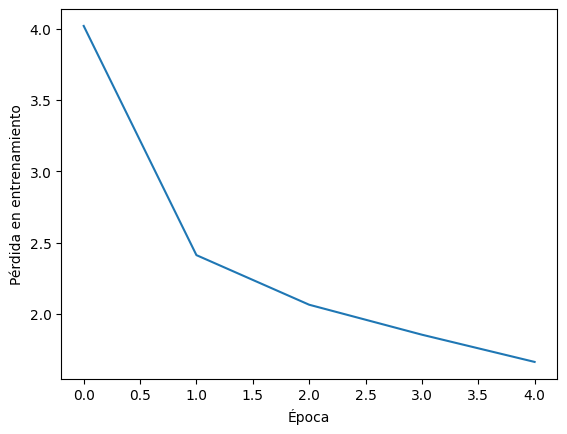

### **Evaluar código**

In [ ]:
grader.run_test("Test 1_5_1", globals())

In [ ]:
grader.run_test("Test 1_5_2", globals())

In [ ]:
grader.run_test("Test 1_5_3", globals())

## **1.6 Evaluación**
---

Finalmente, podemos utilizar los datos reservados de la partición de prueba para evaluar la exactitud o *accuracy* del modelo en la clasificación de entradas nunca antes vistas.

Complete la función **`evaluate_model`** para que retorne la exactitud de un modelo **`model`** sobre los arreglos **`X_test`** y **`y_ohe_test`**.

**Entrada**:

* **model**: `tf.keras.Model`, un modelo de Keras compilado y entrenado.
* **X_test**: `np.array`, una matriz de tamaño `(m,n)`, siendo `m` el número de muestras de los datos de prueba, y `n` el número de _features_.
* **y_ohe_test**: `np.array`, etiquetas *one-hot* del conjunto de prueba, un arreglo de *NumPy* de tamaño `(m, c)`, siendo `c` el número de clases del conjunto de datos.

**Salida**:
* **`acc`**: `float`, el _accuracy_ del modelo en los datos de prueba.

In [ ]:
# FUNCIÓN CALIFICADA evaluate_model:

def evaluate_model(model, X_test, y_ohe_test):
    acc = -1
    return acc

In [ ]:
#TEST CELL prev
y_train_ohe, y_test_ohe = one_hot_labels(y_train, y_test)
test_model = define_model(64, 2, 16, 10)
test_model = compile_model(test_model,
                           tf.keras.losses.categorical_crossentropy,
                           tf.keras.optimizers.Adam(learning_rate=1e-3),
                           metrics = ['acc'])
test_checkpoint, test_stopping = define_callbacks('test_checkpoint.weights.h5', 'loss', 'min', 2)
history, test_model = train_model(test_model,
                             X_train,
                             y_train_ohe,
                             epochs=5,
                             batch_size=64,
                             validation_rate=0.2,
                             callbacks=[test_checkpoint, test_stopping])

In [ ]:
#TEST CELL
acc = evaluate_model(test_model,
                     X_test=X_test,
                     y_ohe_test=y_test_ohe)
print("Accuracy en test:",np.round(acc,4))

**Salida esperada:**
```
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.3878 - loss: 1.6046
Accuracy en test: 0.4186
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 1_6_1", globals())

In [ ]:
grader.run_test("Test 1_6_2", globals())

## **Entrenando durante más _epochs_**
----
En este punto usted ha debido programar con éxito todos los pasos necesairios para entrenar un modelo básico de red neuronal en _Keras_. A continuación vamos a usar su código para el entrenamiento de un modelo de dos capas densas de 16 neuronas. Usaremos el optimizador `Adam` con una tasa de entrenamiento de `1e-2`, monitoreando la función de pérdida en validación con una paciencia de 10 _epochs_, realizando máximo 50 _epochs_, usando un _batch_size_ de 64 muestras y reservando un 20% del conjunto de entrenamiento para validación.

> **Nota: este código no es calificable.**

In [ ]:
final_model = define_model(64, 2, 16, 10)
final_model = compile_model(final_model,
                           tf.keras.losses.categorical_crossentropy,
                           tf.keras.optimizers.Adam(learning_rate=1e-2),
                           metrics = ['acc'])
final_checkpoint, final_stopping = define_callbacks('best_model.weights.h5', 'val_loss', 'min', 10)
history, final_model = train_model(final_model,
                             X_train,
                             y_train_ohe,
                             epochs=50,
                             batch_size=64,
                             validation_rate=0.2,
                             callbacks=[final_checkpoint, final_stopping])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
acc = evaluate_model(final_model,
                     X_test=X_test,
                     y_ohe_test=y_test_ohe)
print("Accuracy en test:",np.round(acc,4))

**Salida esperada:**

```
Epoch 1/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.1268 - loss: 3.4056
Epoch 1: val_loss improved from inf to 1.93804, saving model to best_model.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - acc: 0.1326 - loss: 3.2981 - val_acc: 0.2963 - val_loss: 1.9380
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.3447 - loss: 1.7362
............
EEpoch 29/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.9978 - loss: 0.0106
Epoch 29: val_loss did not improve from 0.20765
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - acc: 0.9978 - loss: 0.0107 - val_acc: 0.9537 - val_loss: 0.2518
Epoch 30/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.9978 - loss: 0.0095
Epoch 30: val_loss did not improve from 0.20765
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - acc: 0.9978 - loss: 0.0095 - val_acc: 0.9537 - val_loss: 0.2422
Epoch 30: early stopping
```

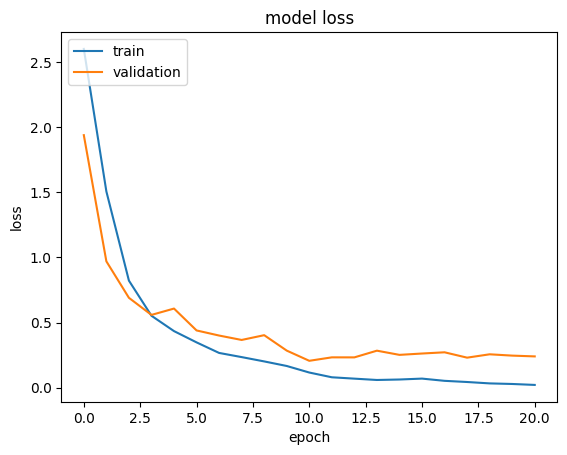
```
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.9264 - loss: 0.2334
Accuracy en test: 0.9263
```

Obtuvimos un _accuracy_ de 92.63% ¡Buen trabajo!

# **2. Regresión**
---

Una tarea de regresión implica modelar una variable continua, no una categórica como lo hemos venido haciendo. Esto tiene dos implicaciones directas en la construcción de un modelo de red neuronal. La primera es que no se puede usar una función de activación tipo `sigmoid` o `softmax` en la salida, sino una activación lineal (o `linear`, que viene por defecto en las capas densas de Keras). La segunda es que la función de pérdida no puede ser una entropía cruzada, sino una que mida qué tan lejos están las predicciones del modelo respecto a los valores reales. **Keras** nos ofrece muchas opciones para esto, pero las más usuales son:

*   `tf.keras.losses.MeanSquaredError`: el error cuadrático medio o MSE por sus siglas en inglés, es la media del cuadrado del error de las predicciones del modelo.
*   `tf.keras.losses.MeanAbsoluteError`: el error medio absolto o MAE por sus siglas en inglés, es la media del error absoluto de las predicciones del modelo.

Comparadas entre sí, el error cuadrático medio penaliza con más fuerza los errores grandes; sin embargo la idea es la misma: penalizar el error de predicción.

Vamos a usar el [conjunto de datos Diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) del repositorio de la *UCI*. Este dataset plantea una tarea de regresión. Cada muestra del conjunto de datos corresponde a un paciente. A partir de información como la edad, sexo, índice de masa corporal, presión arterial media, y seis mediciones del suero sanguineo, el objetivo es predecir el progreso de la enfermedad después de un año de haber tomado los datos del paciente. Este progreso se mide de forma cuantitativa en una variable que puede tomar valores entre 40 y 346. Veamos el resumen de las características importantes del _dataset_:

* Total de muestras: 442
* Dimension de las muestras: 10
* Rango de las *features*: `float`, -0.2 < `x` < 0.2. Es decir, los datos están normalizados.
* Dimensión de la variable objetivo: 1
* Rango de la variable objetivo: `int` 40 <`y`< 346

Vamos a cargar el dataset y definir particiones de entrenamiento y prueba. En este caso no necesitamos una codificación *one-hot*.

In [ ]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target

X_train_2, X_test_2, y_train_2, y_test_2 = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=13
)

Verifiquemos el tamaño de cada partición y el rango de la variable objetivo

In [ ]:
X_train_2.shape, X_test_2.shape, y_train_2.max(), y_test_2.min()

**Salida esperada**
```python
((309, 10), (133, 10), 346.0, 40.0)

```

Es decir, tenemos 309 _samples_ para _train_, 133 para _test_, 10 _features_, y el rango de la variable objetivo va desde 40 hasta 346.

## **2.1 Definición del modelo**
---

Similar al ejercicio 1.2, vamos a definir la arquitectura del modelo. Complete la función `define_regressor`, que crea un modelo en **Keras** con las siguientes especificaciones:

* Debe utilizar el API funcional de **Keras** (no puede ser un modelo secuencial).
* Debe tener una capa de entrada con las dimensiones del dataset.
* Debe permitir agregar una serie de capas densa con activación *ReLU* (por lo menos una).
* Debe tener una capa densa de salida con tantas unidades como la dimensión de la variable objetivo, y con una activación *linear*.

**Entrada**:

* **`input_shape`**: un número entero correspondiente a la dimensión de entrada del modelo.
* **`hidden_layers`**: un número entero correspondiente al número de capas ocultas.
* **`hidden_units`**: un número entero correspondiente al número de neuronas de las capas ocultas.
* **`output_units`**: un número entero correspondiente al número de neuronas de la capa de salida.

**Salida**:
* **`model`**: un modelo de red neuronal en **Keras**.

In [ ]:
# FUNCIÓN CALIFICADA define_regressor:

def define_regressor(input_shape, hidden_layers, hidden_units, output_units):
    # Fijamos una semilla para efectos de reproducibiidad
    tf.keras.utils.set_random_seed(0)
    input_layer = tf.keras.layers.Input(shape=(input_shape,))
    # Su código va aquí:

    output_layer = tf.keras.layers.Dense(units=output_units, activation="linear")(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

La siguiente celda usa la función que usted creó para definir un modelo de dos capas densas de 8 neuronas y una salida unidimensional, para poder usarlo en el problema de Diabetes:

In [ ]:
#TEST_CELL
test_model_2 = define_regressor(10, 2, 8, 1)
print(test_model_2.summary())

**Salida esperada:**
```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 169 (676.00 B)
 Trainable params: 169 (676.00 B)
 Non-trainable params: 0 (0.00 B)
None
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 2_1_1", globals())

In [ ]:
grader.run_test("Test 2_1_2", globals())

In [ ]:
grader.run_test("Test 2_1_3", globals())

In [ ]:
grader.run_test("Test 2_1_4", globals())

In [ ]:
grader.run_test("Test 2_1_5", globals())

In [ ]:
grader.run_test("Test 2_1_6", globals())

In [ ]:
grader.run_test("Test 2_1_7", globals())

## **2.2 Compilación y entrenamiento**
---

Vamos a usar las funciones que definió anteriormente para compilar y definir callbacks.

Complete la función `train_regressor` que recibe un modelo, y los parámetros necesarios para compilarlo y entrenarlo, y devuelve un objeto tipo `History` junto con el modelo entrenado.

**Entrada**:

* **model**: un modelo de Keras.
* **filepath**: un `str` de la dirección para guardar el modelo y/o los pesos.
* **X_train**: Los datos de entrenamiento.
* **y_train**: Las etiquetas de los datos de entrenamiento.
* **epochs**: el número máximo de epochs para entrenar.
* **batch_size**: el tamaño del *batch* que se usa en cada iteración de entrenamiento.
* **learning_rate**: la tasa de aprendizaje.
* **validation_rate**: el porcentaje (en número de 0 a 1) de datos de entrenamiento que se usarán para validar.

**Salida**:
* **`history`**: un objeto tipo `History` de tensorflow con la información del entrenamiento del modelo.
* **`model`**: el modelo entranado.

**Notas Importantes:** la función `train_regressor` por defecto retorna un modelo con las siguientes especificaciones:

* La función de ṕerdida debe ser el **Mean Absolute Error o MAE**.

* Debe usar un optimizador *Adam*.

* Debe estar configurado para monitorear la función de pérdida en validación durante el entrenamiento, con una paciencia de 10 epochs.

* Debe reportar la métrica **Mean Absolute Error o MAE**.





In [ ]:
# FUNCIÓN CALIFICADA train_regressor:

def train_regressor(model, filepath, X_train, y_train, epochs, batch_size,
                    learning_rate, validation_rate):
    model = compile_model(
                          )
    callbacks = define_callbacks(
                          )
    history = model.fit(
                          )
    return history, model

En la siguiente celda, usaremos su código para entrenar el modelo durante máximo 50 epochs, usando un tamaño de _batch_ de 64, una tasa de aprendizaje de 0.05, y reservando el 20% del conjunto de entrenamiento para validación:

In [ ]:
#TEST CELL prev
test_model_2 = define_regressor(10, 2, 8, 1)

In [ ]:
#TEST CELL
history, test_model_2 = train_regressor(model=test_model_2,
                                        filepath='best_regressor.weights.h5',
                                        X_train=X_train_2,
                                        y_train=y_train_2,
                                        epochs=50,
                                        batch_size=64,
                                        learning_rate=5e-2,
                                        validation_rate=0.2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Salida esperada:**

```
Epoch 1/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 149.7544 - mae: 149.7544
Epoch 1: val_loss improved from inf to 162.67799, saving model to best_regressor.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 149.7141 - mae: 149.7141 - val_loss: 162.6780 - val_mae: 162.6780
Epoch 2/50
...........
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 43.5077 - mae: 43.5077
Epoch 50: val_loss did not improve from 46.27600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 43.1553 - mae: 43.1553 - val_loss: 46.7165 - val_mae: 46.7165
Restoring model weights from the end of the best epoch: 48.

```

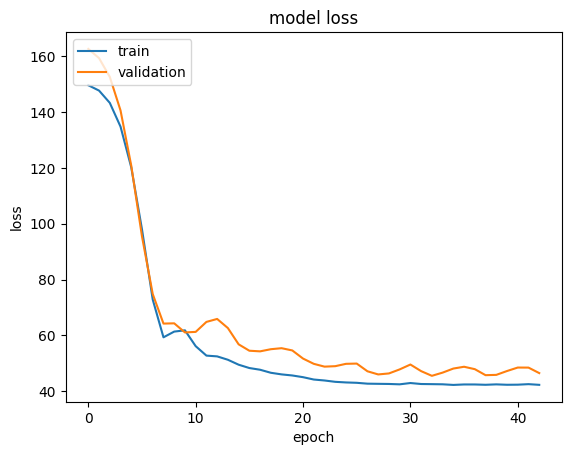

### **Evaluar código**

In [ ]:
grader.run_test("Test 2_2_1", globals())

In [ ]:
grader.run_test("Test 2_2_2", globals())

In [ ]:
grader.run_test("Test 2_2_3", globals())

## **2.3 Evaluación**
---

Ahora vamos a utilizar los datos reservados de la partición de prueba para evaluar la exactitud o *accuracy* del modelo en la clasificación de entradas nunca antes vistas.

Complete la función **`evaluate_model`** para que retorne la exactitud de un modelo **`model`** sobre los arreglos **`X_test`** y **`y_test`**.

**Entrada**:

* **`model`**: un modelo de Keras compilado y entrenado.
* **`X_test`**: Los datos de prueba.
* **`y_test`**: Las etiquetas de los datos de prueba.

**Salida**:
* **`mae`**: el error medio absoluto del modelo en los datos de prueba.

In [ ]:
# FUNCIÓN CALIFICADA evaluate_regressor:

def evaluate_regreesor(model, X_test, y_test):
    mae = -1
    return mae

In [ ]:
#TEST CELL prev
test_model_2 = define_regressor(10, 2, 8, 1)
history, test_model_2 = train_regressor(model=test_model_2,
                                        filepath='best_regressor.weights.h5',
                                        X_train=X_train_2,
                                        y_train=y_train_2,
                                        epochs=50,
                                        batch_size=64,
                                        learning_rate=5e-2,
                                        validation_rate=0.2)

In [ ]:
#TEST CELL
mae = evaluate_regreesor(test_model_2,
                     X_test=X_test_2,
                     y_test=y_test_2)
print("MEA en test:",np.round(mae,4))

Es decir, en el conjunto de prueba tenemos un error medio absoluto de 44.67.

**Salida esperada:**
```
MEA en test: 44.6665
```

### **Evaluar código**

In [ ]:
grader.run_test("Test 2_3_1", globals())

In [ ]:
grader.run_test("Test 2_3_2", globals())

# **Evaluación**


In [ ]:
grader.submit_task(globals())

# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/)
  * [Juan Sebastián Lara](https://http://juselara.com/)
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](mailto:mrodrigueztr@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*